# Notes
notes for class Applied Machine Learning

### Compare two ML model
* time to fit/build the model
* memory to store
* time to predict

### Parametric vs Non-Parametric model
* parametric model has a fixed set of parameters that we learn from data
	* trees, forests, SVMs
* non-p model scales complexity with number of data
	* linear models

### Cross Validation
* Three-fold split
	* training set, validation set, test set
* Process of tuning parameters (hyper parameters | not model parameters)
	0. start with: (1) a dataset, (2) a candidate set of parameters we want to try 
	1. split dataset into training and test
		* scikit learn: not stratify in defalut 
		* good to train_test_split(X, y, stratify=y)
	2. cross validation on training set --> find best setting for parameters
	4. retrain on whole training set use the best param 
	5. evaluate on test (ONCE!)
* Strategies
	* usualy 5 or 10, scikit learn default 3
	* standard k-fold just split fold by order.
	* stratified k-fold: (most commonly)
		* Preserve the class frequencies in each fold to be the same as overall dataset
		* scikitlearnl: defalt cv is stratified, BUT not shuffle
	* LOO - leave 1 out: (bad. high variance, long time)
		* k = n_sample
	* repeated k-fold:
		* run k-fold cv multiple times with shuffle
	* shuffle split/ stratified shuffle split
		* specify #iterations, training set size, and test set (validation) size.
		* repeatly sample disjoint training and test set randomly
	* GCV - group k-fold: 
		* for data not IID, and has correaltions between samples
		* there are several groups in the data taht each contain highly correlated samples
		* each group is contained in exact one fold (one fold may have multiple groups)
	* time series split
		* for data not IID, and correlated with time
		* split fold by time
		* always test on the last chunk (predict future data)
		* training sets are overlapping with test in this case.

	 

### Efficient Cross Validation
Models with build-in cross validation
* RidgeCV()
	* GCV, approximation to LOO
	* we cannot pick CV
* LarsCV()
* LassoLarsCV()
* ElasticNetCV()
* Use path algorithm to compute the full solution path
* LogisticRegressionCV() uses warm-starts, doesn't support all solvers
* all have resonable build-in parameter grids


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [10]:
# Simple dataset for KNN

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(centers=2, cluster_std=2, random_state=0, n_samples=500)

# default 75% 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

##### Cross Validation Generators

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# default n_neighbor in this example 5
kfold = KFold(n_splits=5)
skfold = StratifiedKFold(n_splits=5, shuffle=True)
ss = ShuffleSplit(n_splits=20, train_size=.4, test_size=.3)

print("KFold:\n{}".format(cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=kfold)))
print("SKFold:\n{}".format(cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=skfold)))
print("Shuffle Split:\n{}".format(cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=ss)))

KFold:
[ 0.78666667  0.78666667  0.8         0.81333333  0.8       ]
SKFold:
[ 0.80263158  0.76315789  0.77333333  0.78378378  0.87837838]
Shuffle Split:
[ 0.73451327  0.79646018  0.85840708  0.79646018  0.80530973  0.78761062
  0.79646018  0.85840708  0.79646018  0.81415929  0.77876106  0.78761062
  0.69911504  0.81415929  0.82300885  0.77876106  0.80530973  0.84070796
  0.83185841  0.73451327]


##### Grid Search

In [8]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd


# add grid search to iterate different param settings
param_grid = {'n_neighbors': np.arange(1, 15, 2)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

print("best mean cv scores: {:.3f}".format(grid.best_score_))
print("best params: {}". format(grid.best_params_))

print("test set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cv scores: 0.824
best params: {'n_neighbors': 13}
test set score: 0.768


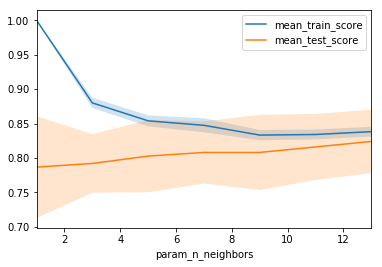

In [12]:
results = pd.DataFrame(grid.cv_results_)
results.plot('param_n_neighbors', 'mean_train_score')
results.plot('param_n_neighbors', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_n_neighbors.astype(np.int),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_n_neighbors.astype(np.int),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()

## Supervised Learning

### K Nearest Neighbors - KNN
* Distance can be any
* more neighbors --> more simplify boundry; less --> more complex shape 

In [14]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("accuracy: {:.2f}".format(knn.score(X_test, y_test)))

accuracy: 0.77


### Nearest Centroid - NC
* limit to linear dicision boundries!
* Computes the centroid or the mean of each class
* classifes each point by which centroid is the closest


In [15]:
from sklearn.neighbors import NearestCentroid

nc = NearestCentroid()
nc.fit(X_train, y_train)
print("accuracy: {:.2f}".format(nc.score(X_test, y_test)))

accuracy: 0.80


### Nearest Shrunken Centroid
* pick a positive shrinking threshold
* moving the centroid towards zero by threshold
* For example if threshold was 2.0, a centroid of 3.2 would be shrunk to 1.2, a centroid of -3.4 would be shrunk to -1.4, and a centroid of 1.2 would be shrunk to zero.
* the new sample is classified by the usual nearest centroid rule, but using the shrunken class centroids.
* 0 will be ignored (a selection)
* limit model complexity

### KNN vs NC
* n = n_samples, p = n_features
* time: O(p*nlogn) vs O(n*p)
* memory: O(n*p) vs O(n_classes * p) 
* predict: O(k*logn) for fixed p vs O(n_classes * p)
* KNN memroy scales with data and slow on high dimention, large dataset

## Regression
* Ridge - l2 palnalize equally
* Lasso - l1 feature selection
* Elastic Net - l1+l2
* Robust Fit - reduece influence of outliers
	* RANSAC - modeling on a subset of data and pick best
	* Huber Loss - threshold, and quadratic within threshold, linear outside

In [13]:
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np
plt.rcParams['figure.dpi'] = 300

In [15]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.datasets import load_boston
boston = load_boston()

from sklearn.utils import shuffle
X, y = boston.data, boston.target
X, y = shuffle(X, y)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# random_state=42 used for random sampling

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, scale


param_grid = {'alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(Ridge(), param_grid, cv=5)
grid.fit(X_train, y_train)

# add features
X_poly = PolynomialFeatures(include_bias=False).fit_transform(scale(X_train))
print(X_train.shape)
print(np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=10)))
print(np.mean(cross_val_score(Ridge(), X_train, y_train, cv=10)))

LinearRegression.fit

ridge100 = Ridge(alpha=100).fit(X_train, y_train)

ridge1 = Ridge(alpha=1).fit(X_train, y_train)

print(ridge1.coef_.shape)

(379, 13)
0.661957948937
0.657160215671
(13,)


* Regulization -- lots of regulization limits the influence of individual points

### Linear Model for binary Classification
* LogReg - if we need/or not need probability estimate
	* Logistic regression
	* Penalized Logistic Regression (C is inverse of alpha --> small C - lots of regulization)
* SVM - if do not need probability estimate

### Linear Model for multi Classification
* Reduction to binary classification
	* 1 vs rest (standard!)
		* n binary classifiers
		* if we have 4 classes --> 4 binary classifiers 1 vs {2,3,4} etc..
		* prediction: class with highest score
	* 1 vs 1
		* n*(n-1)/2 binary classifiers
		* prediction: .....
* Multinomial Logistic Regression
	* same rules as OvR

##### In scikit learn
* OvO: only SVC
* OvR: default for all linear models, include logistic regression

#### Computational consideration
* liear SVC: USE `LinearSVC` instead of `SVC(kernel='linear')`, `LinearSVC` is faster
* n_features >> n_samples: `Lars` instead of `Lasso`

when n_sample > 10,000
* `LinearSVC`, `Logistic`: `dual=False` if n_samples >> n_features
* `LogisticRegression(solver="sag")` for large n_samples.
* Stochastic Gradient Descent for "n_samples really large"

In [5]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import numpy as np

iris = load_iris()
X, y = iris.data, iris.target

# count number of obs. in each category
np.bincount(y)

print(X.shape)
print(y.shape)
print(np.bincount(y))

logreg = LogisticRegression(multi_class="multinomial", solver="lbfgs").fit(X, y)
linearsvm = LinearSVC().fit(X, y)

print(logreg.coef_.shape)
print(linearsvm.coef_.shape)
# 3 categories and 4 features
print(logreg.coef_)

print(logreg)

(150, 4)
(150,)
[50 50 50]
(3, 4)
(3, 4)
[[-0.42340381  0.96173902 -2.51955766 -1.08586558]
 [ 0.53419549 -0.318011   -0.20539083 -0.93973403]
 [-0.11079168 -0.64372803  2.72494848  2.0255996 ]]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
